In [2]:
import os
wav_path = '/home/wjunneng/Ubuntu/2019-FlyAI-Life-Scene-Chinese-Speech-Recognition/SincNet/data/input/wav'

wav_file_list = os.listdir(wav_path)

In [3]:
import wave

# nchannels: 声道
# sampwidth: 采样宽度
# framerate: 帧速率/采样的频率
# nframes: 帧数/采样点个数
# comptyoe: 唯一标识
# compname: 无损

'''
每个采样点是16 bit = 2 bytes
'''

for wav_file in wav_file_list:
    with wave.open(os.path.join(wav_path, wav_file), 'rb') as file:
        print(file.getparams())

_wave_params(nchannels=1, sampwidth=2, framerate=48000, nframes=432000, comptype='NONE', compname='not compressed')
_wave_params(nchannels=1, sampwidth=2, framerate=48000, nframes=489600, comptype='NONE', compname='not compressed')
_wave_params(nchannels=1, sampwidth=2, framerate=48000, nframes=162432, comptype='NONE', compname='not compressed')
_wave_params(nchannels=1, sampwidth=2, framerate=48000, nframes=162432, comptype='NONE', compname='not compressed')
_wave_params(nchannels=1, sampwidth=2, framerate=48000, nframes=256896, comptype='NONE', compname='not compressed')
_wave_params(nchannels=1, sampwidth=2, framerate=48000, nframes=407808, comptype='NONE', compname='not compressed')
_wave_params(nchannels=1, sampwidth=2, framerate=48000, nframes=177408, comptype='NONE', compname='not compressed')
_wave_params(nchannels=1, sampwidth=2, framerate=48000, nframes=392832, comptype='NONE', compname='not compressed')
_wave_params(nchannels=1, sampwidth=2, framerate=48000, nframes=321408, 

In [16]:
import soundfile
import numpy as np
from matplotlib import pyplot as plt
from scipy.io import wavfile

def draw(file_path):    
    file = wave.open(file_path)
    # 采样点个数
    a = file.getparams().nframes  
    # 采样频率
    f = file.getparams().framerate  
    # 采样点的时间间隔
    sample_time = 1 / f  
    # 20毫秒左右
    print('一帧持续的时间{}'.format(sample_time))
    # 声音信号的长度
    time = a / f
    
    # audio_sequence: 声音信号每一帧的“大小” 
    sample_frequency, audio_sequence = wavfile.read(file_path)
    x_seq = np.arange(0, time, sample_time)
    x_seq = x_seq[:audio_sequence.shape[0], ]
    print('x_seq.shape:{}, audio_sequence.shape:{}'.format(x_seq.shape, audio_sequence.shape))
    plt.plot(x_seq, audio_sequence, 'blue')
    plt.xlabel("time (s)")
    plt.show()

一帧持续的时间2.0833333333333333e-05
x_seq.shape:(432000,), audio_sequence.shape:(432000,)
一帧持续的时间2.0833333333333333e-05
x_seq.shape:(489600,), audio_sequence.shape:(489600,)
一帧持续的时间2.0833333333333333e-05
x_seq.shape:(162432,), audio_sequence.shape:(162432,)
一帧持续的时间2.0833333333333333e-05
x_seq.shape:(162432,), audio_sequence.shape:(162432,)
一帧持续的时间2.0833333333333333e-05
x_seq.shape:(256896,), audio_sequence.shape:(256896,)
一帧持续的时间2.0833333333333333e-05
x_seq.shape:(407808,), audio_sequence.shape:(407808,)
一帧持续的时间2.0833333333333333e-05
x_seq.shape:(177408,), audio_sequence.shape:(177408,)
一帧持续的时间2.0833333333333333e-05
x_seq.shape:(392832,), audio_sequence.shape:(392832,)
一帧持续的时间2.0833333333333333e-05
x_seq.shape:(321408,), audio_sequence.shape:(321408,)
一帧持续的时间2.0833333333333333e-05
x_seq.shape:(167040,), audio_sequence.shape:(167040,)
一帧持续的时间2.0833333333333333e-05
x_seq.shape:(217728,), audio_sequence.shape:(217728,)
一帧持续的时间2.0833333333333333e-05
x_seq.shape:(425088,), audio_sequence.shape:(4

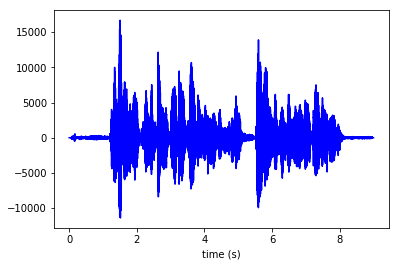

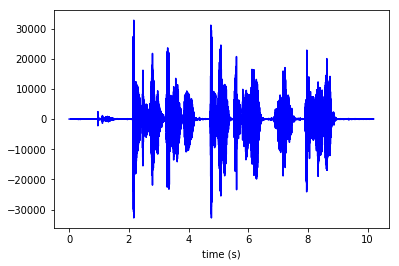

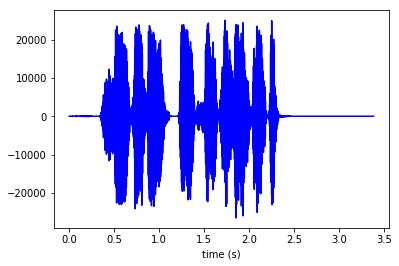

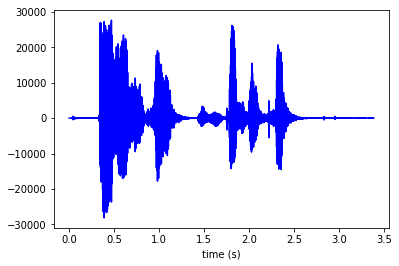

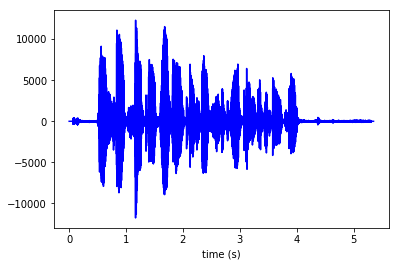

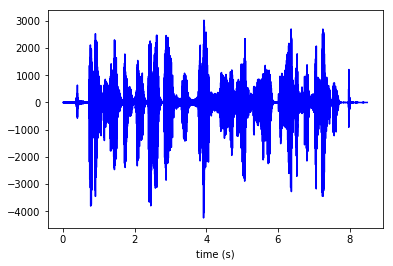

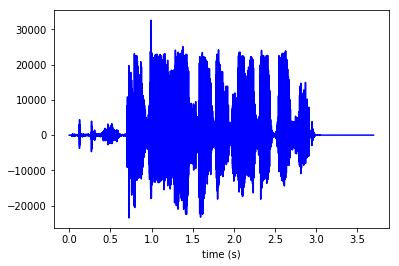

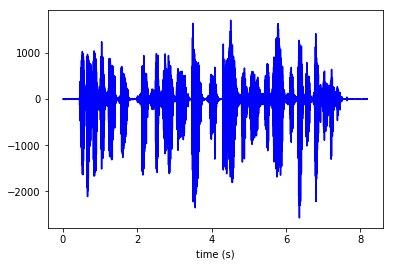

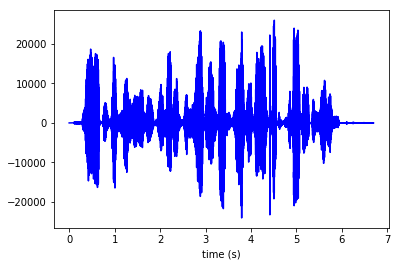

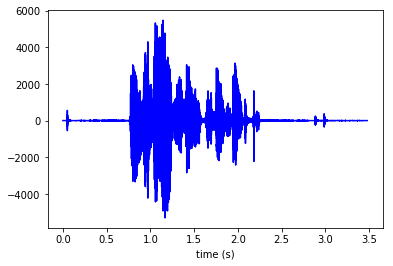

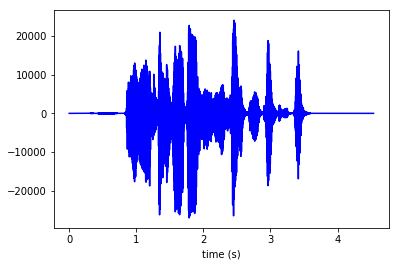

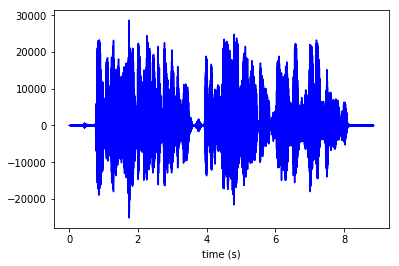

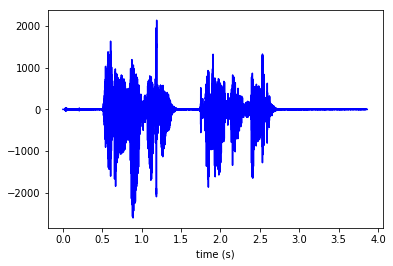

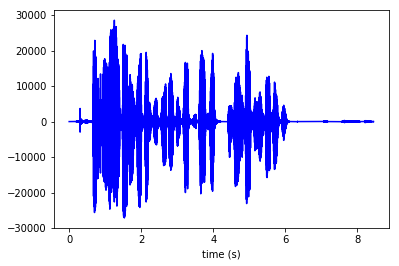

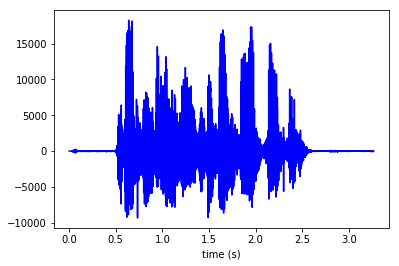

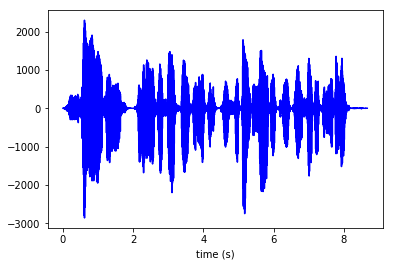

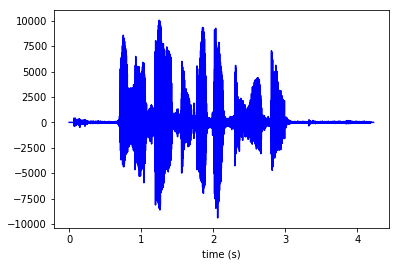

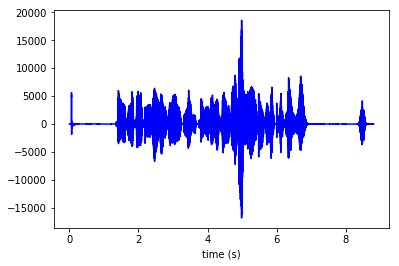

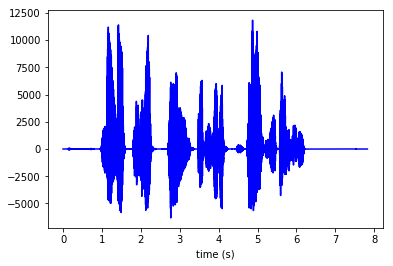

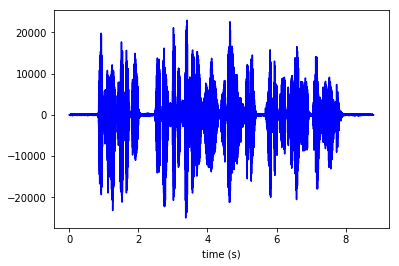

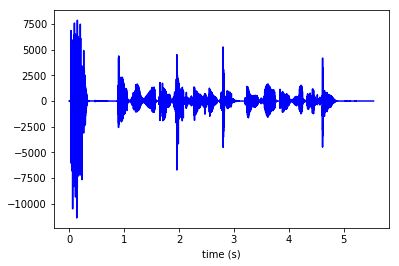

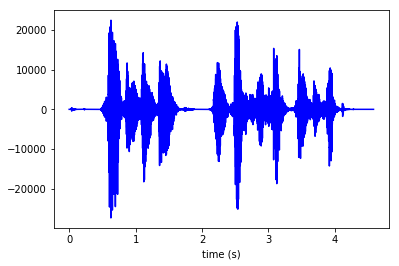

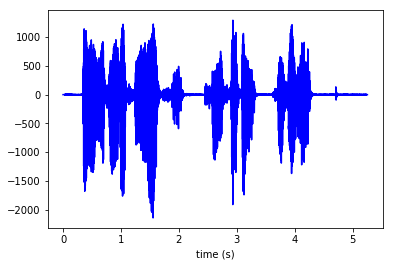

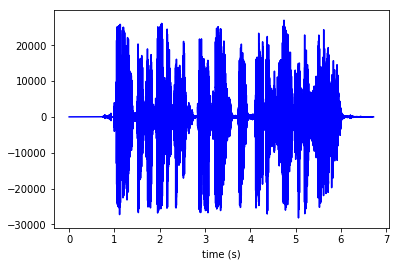

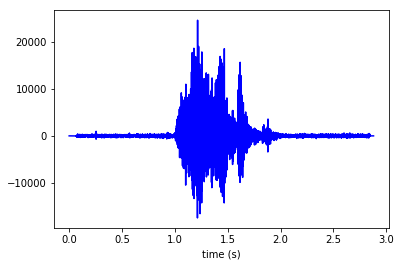

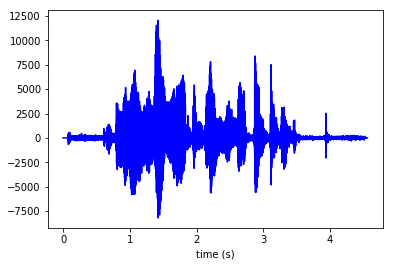

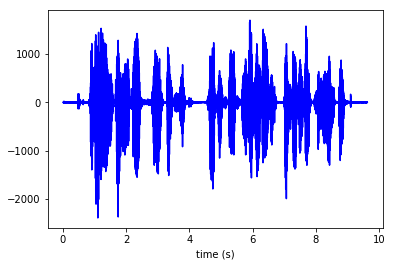

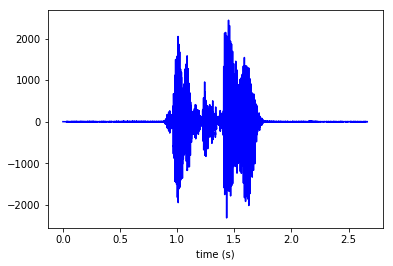

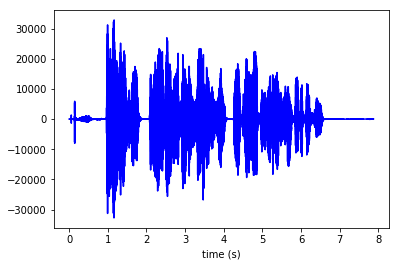

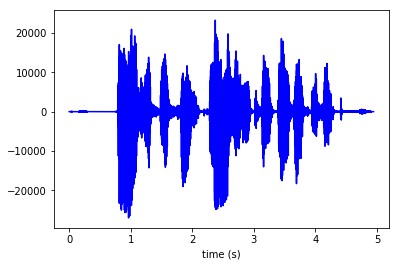

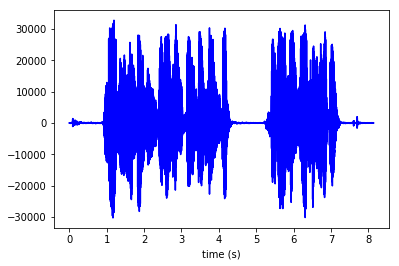

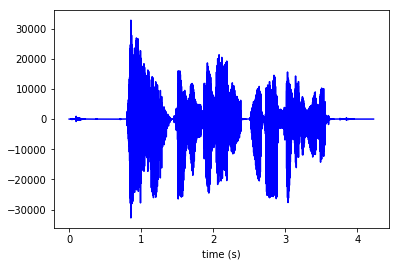

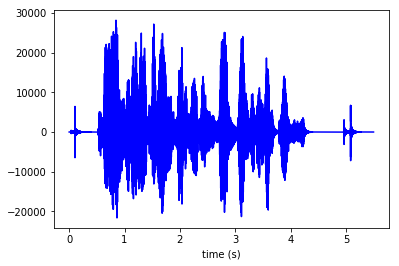

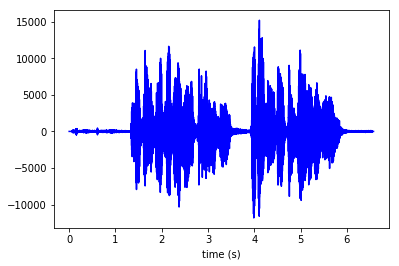

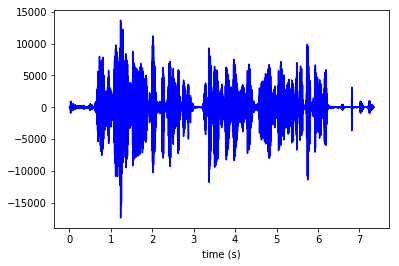

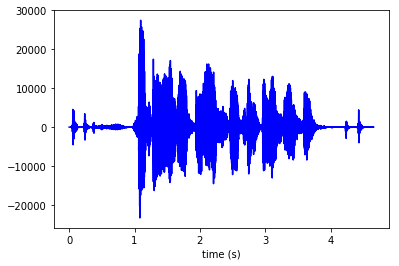

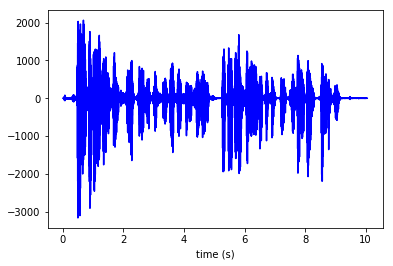

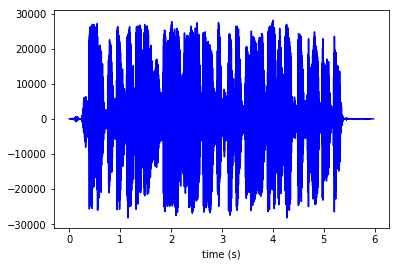

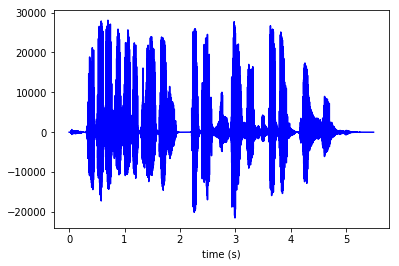

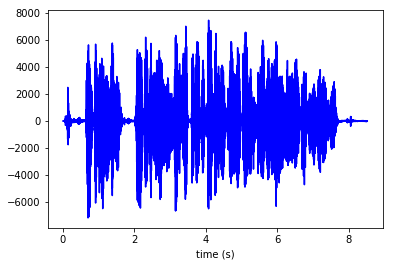

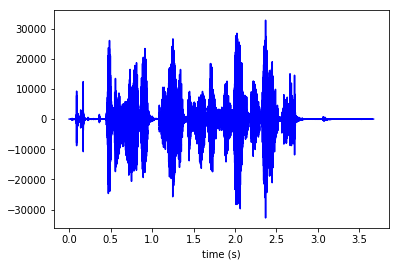

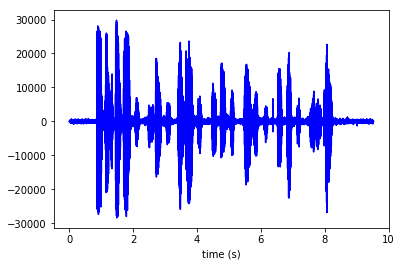

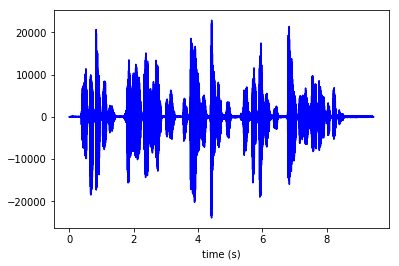

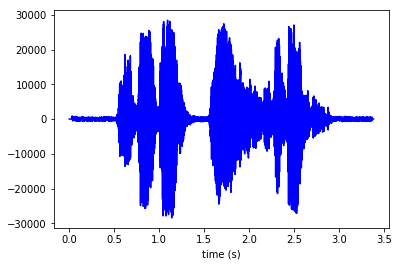

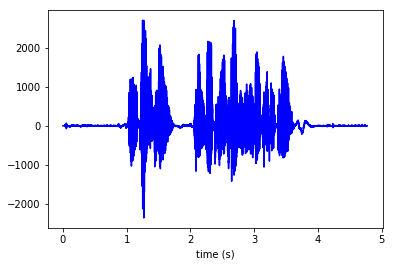

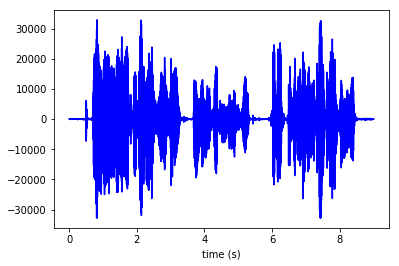

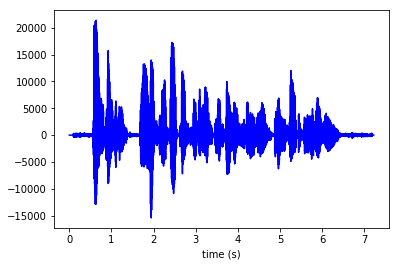

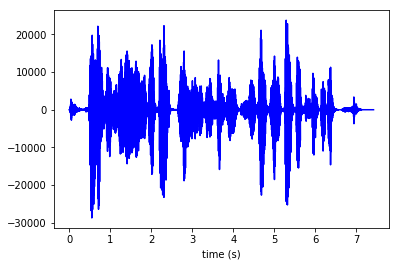

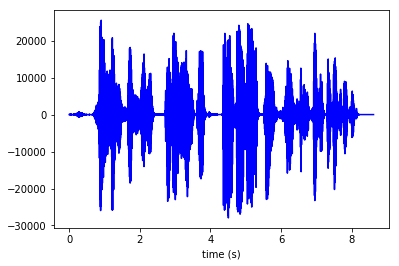

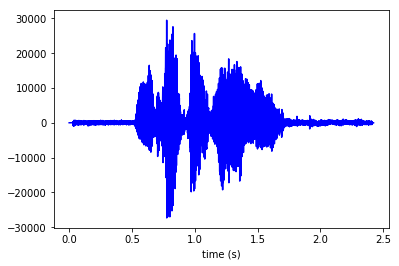

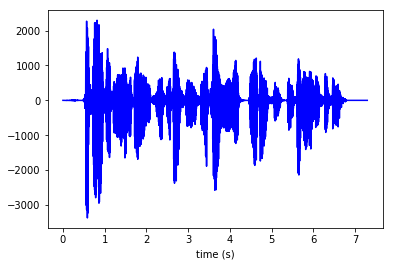

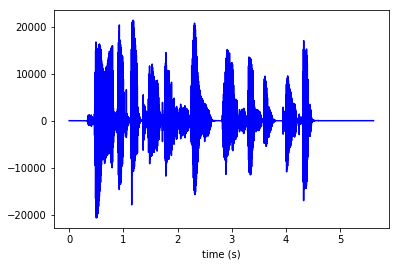

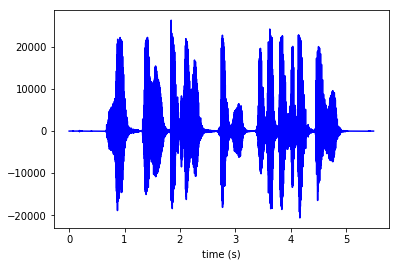

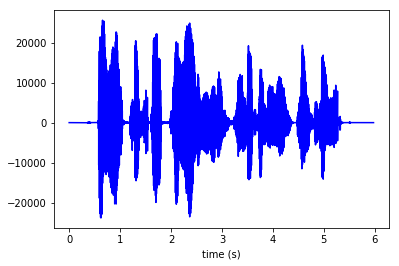

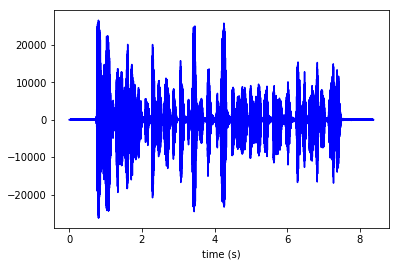

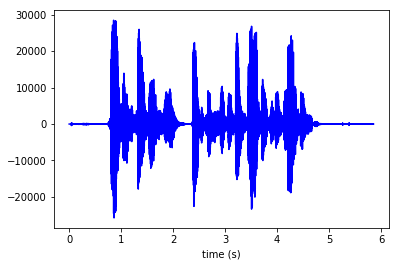

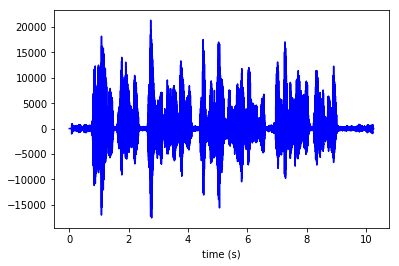

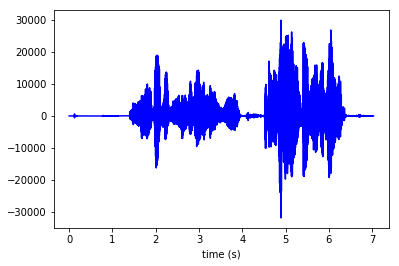

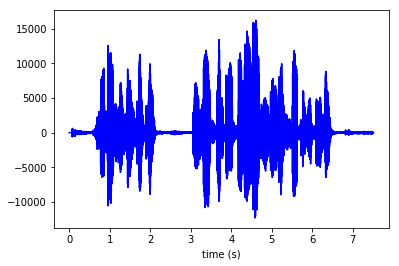

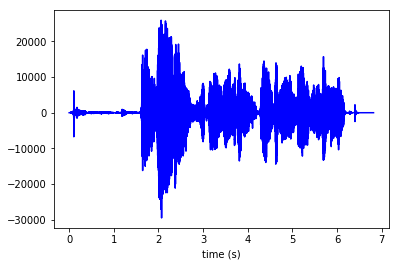

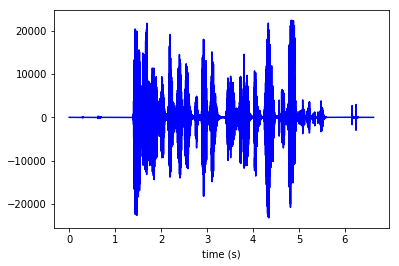

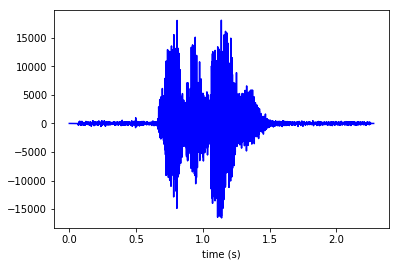

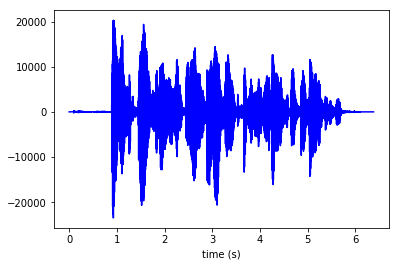

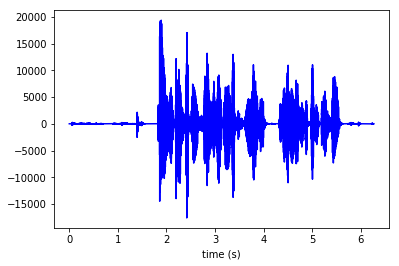

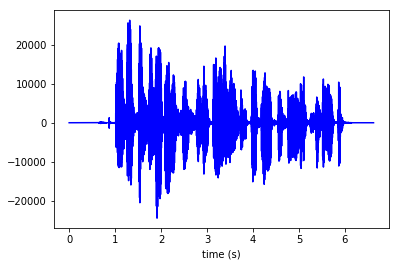

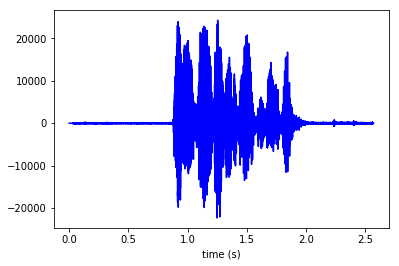

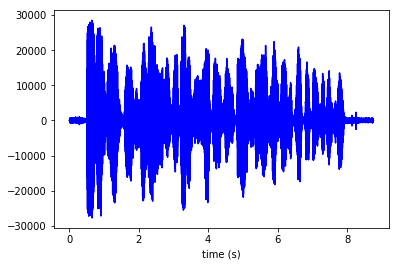

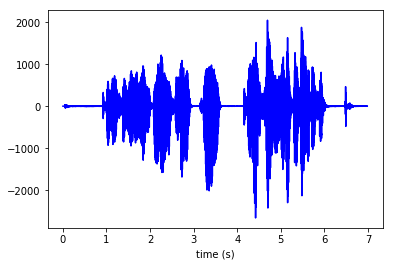

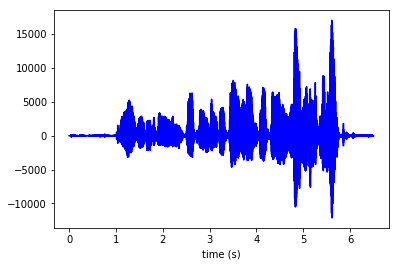

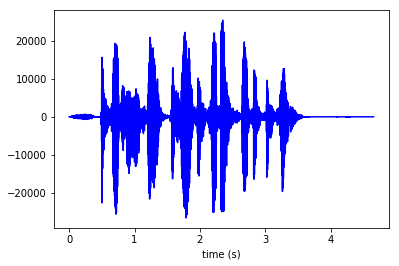

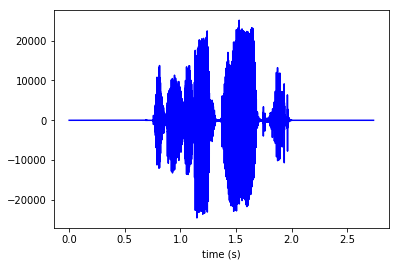

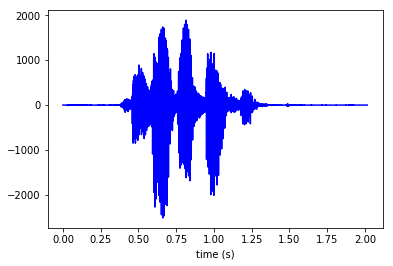

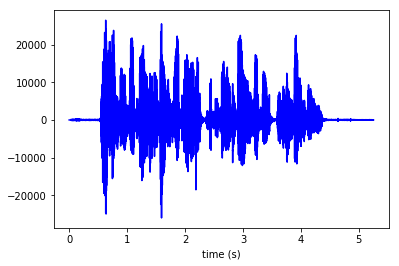

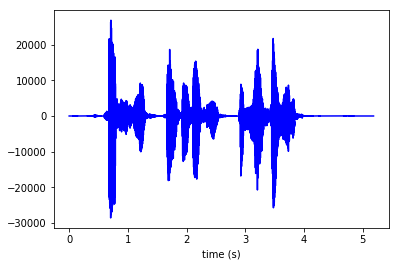

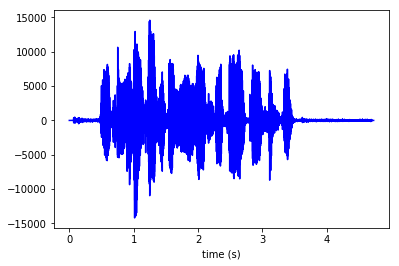

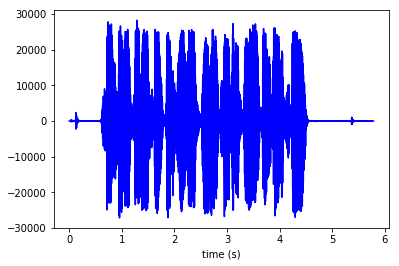

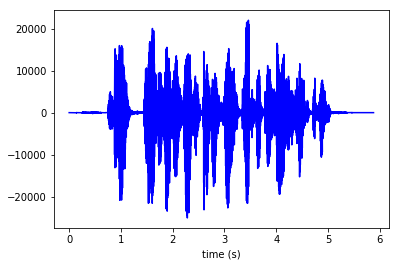

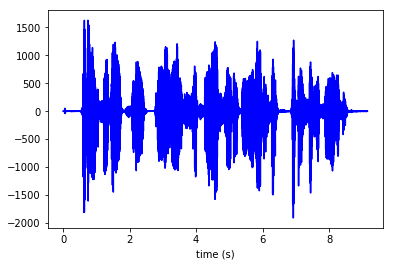

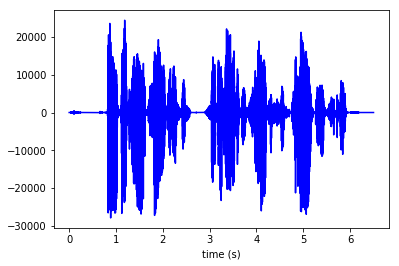

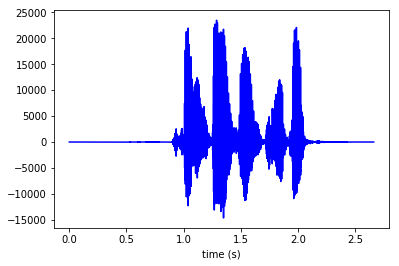

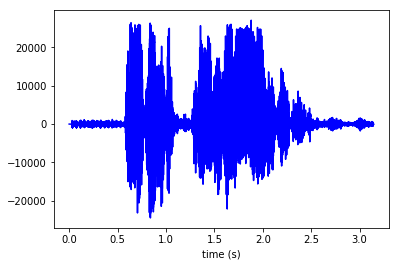

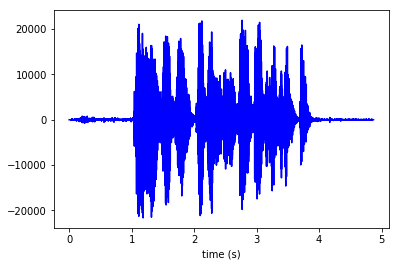

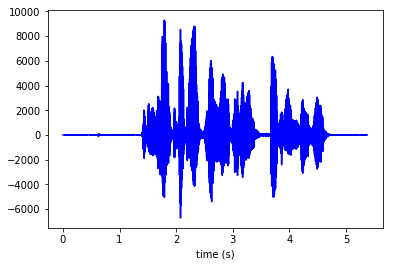

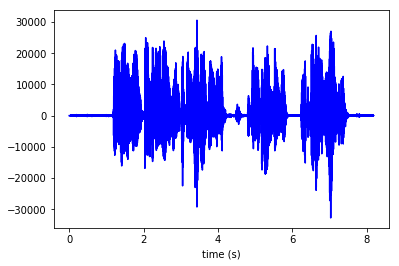

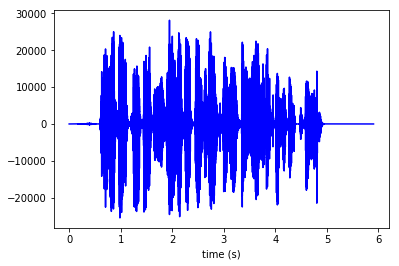

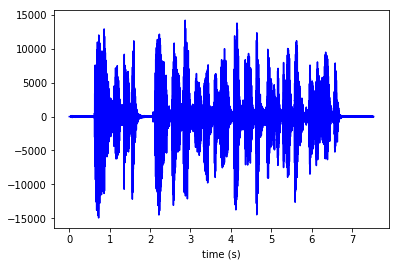

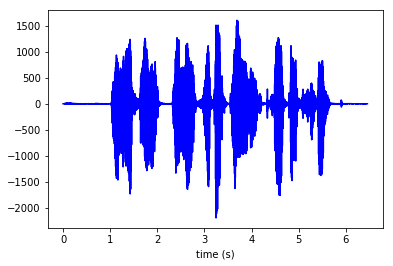

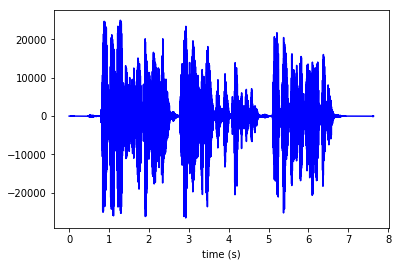

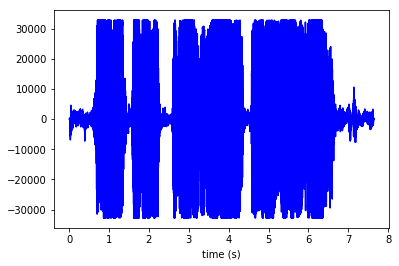

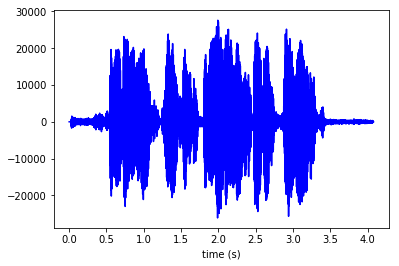

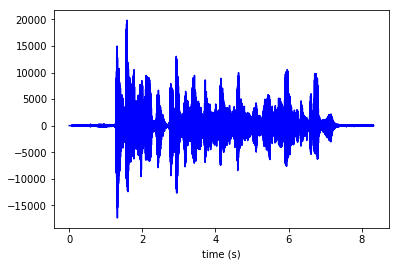

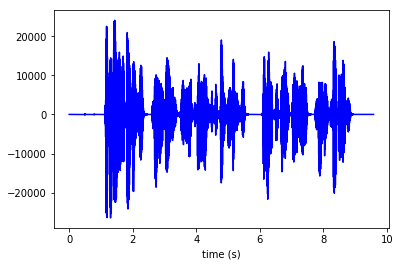

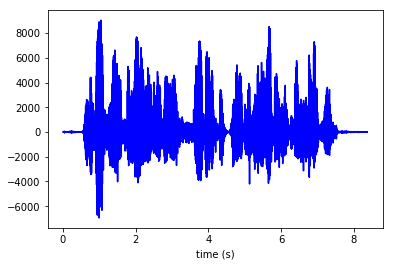

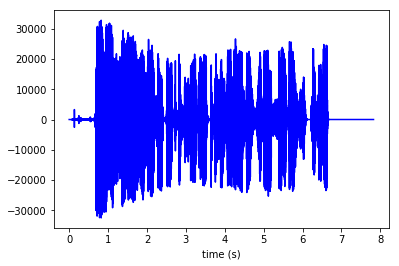

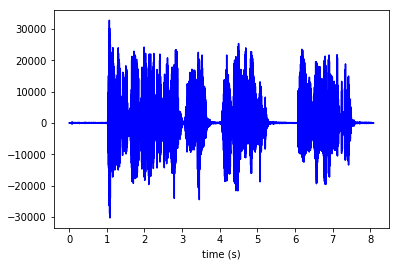

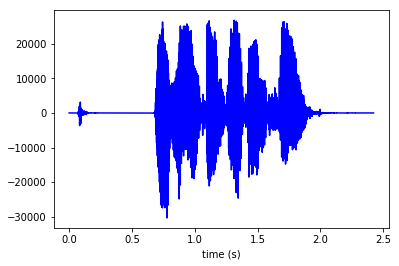

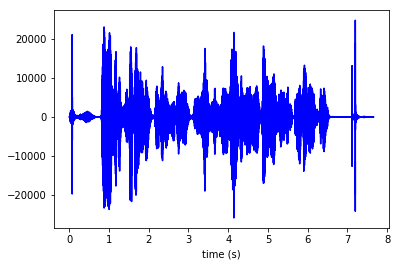

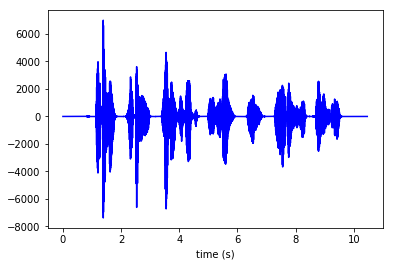

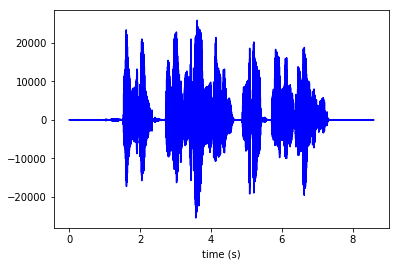

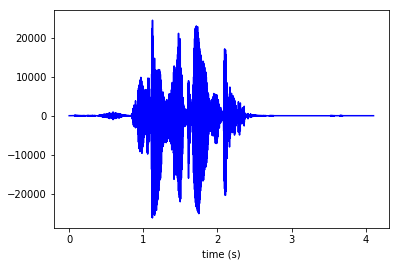

In [17]:
import os

for path in os.listdir(wav_path):
    draw(file_path = os.path.join(wav_path, path))    


In [23]:
import numpy as np
import wave
import math
import ctypes as ct
import os


class FloatBits(ct.Structure):
    _fields_ = [
        ('M', ct.c_uint, 23),
        ('E', ct.c_uint, 8),
        ('S', ct.c_uint, 1)
    ]


class Float(ct.Union):
    _anonymous_ = ('bits',)
    _fields_ = [
        ('value', ct.c_float),
        ('bits', FloatBits)
    ]


def nextpow2(x):
    if x < 0:
        x = -x
    if x == 0:
        return 0
    d = Float()
    d.value = x
    if d.M == 0:
        return d.E - 127
    return d.E - 127 + 1


def denoising(input_wav, output_wav):
    # 打开WAV文档
    f = wave.open(input_wav)
    # 读取格式信息
    # (nchannels, sampwidth, framerate, nframes, comptype, compname)
    params = f.getparams()
    nchannels, sampwidth, framerate, nframes = params[:4]
    fs = framerate
    # 读取波形数据
    str_data = f.readframes(nframes)
    f.close()
    # 将波形数据转换为数组
    x = np.fromstring(str_data, dtype=np.short)
    # 计算参数
    # 样本中帧的大小
    len_ = 20 * fs // 1000  
    # 窗口重叠占帧的百分比
    PERC = 50  
    # 重叠窗口
    len1 = len_ * PERC // 100  
    # 非重叠窗口
    len2 = len_ - len1  
    # 设置默认参数
    Thres = 3
    Expnt = 2.0
    beta = 0.002
    G = 0.9
    # 初始化汉明窗
    win = np.hamming(len_)
    # normalization gain for overlap+add with 50% overlap
    winGain = len2 / sum(win)

    # Noise magnitude calculations - assuming that the first 5 frames is noise/silence
    nFFT = 2 * 2 ** (nextpow2(len_))
    noise_mean = np.zeros(nFFT)

    j = 0
    for k in range(1, 6):
        noise_mean = noise_mean + abs(np.fft.fft(win * x[j:j + len_], nFFT))
        j = j + len_
    noise_mu = noise_mean / 5

    # --- allocate memory and initialize various variables
    k = 1
    img = 1j
    x_old = np.zeros(len1)
    Nframes = len(x) // len2 - 1
    xfinal = np.zeros(Nframes * len2)

    # =========================    Start Processing   ===============================
    for n in range(0, Nframes):
        # Windowing
        insign = win * x[k - 1:k + len_ - 1]
        # compute fourier transform of a frame
        spec = np.fft.fft(insign, nFFT)
        # compute the magnitude
        sig = abs(spec)

        # save the noisy phase information
        theta = np.angle(spec)
        SNRseg = 10 * np.log10(np.linalg.norm(sig, 2) ** 2 / np.linalg.norm(noise_mu, 2) ** 2)

        def berouti(SNR):
            a = 0
            if -5.0 <= SNR <= 20.0:
                a = 4 - SNR * 3 / 20
            else:
                if SNR < -5.0:
                    a = 5
                if SNR > 20:
                    a = 1
            return a

        def berouti1(SNR):
            a = 0
            if -5.0 <= SNR <= 20.0:
                a = 3 - SNR * 2 / 20
            else:
                if SNR < -5.0:
                    a = 4
                if SNR > 20:
                    a = 1
            return a

        if Expnt == 1.0:
            # 幅度谱
            alpha = berouti1(SNRseg)        
        else:  
            # 功率谱
            alpha = berouti(SNRseg)
        
        #############
        sub_speech = sig ** Expnt - alpha * noise_mu ** Expnt
        # 当纯净信号小于噪声信号的功率时
        diffw = sub_speech - beta * noise_mu ** Expnt
        # beta negative components

        def find_index(x_list):
            index_list = []
            for i in range(len(x_list)):
                if x_list[i] < 0:
                    index_list.append(i)
            return index_list

        z = find_index(diffw)
        if len(z) > 0:
            # 用估计出来的噪声信号表示下限值
            sub_speech[z] = beta * noise_mu[z] ** Expnt
            # --- implement a simple VAD detector --------------
        if SNRseg < Thres:  
            # 平滑处理噪声功率谱
            noise_temp = G * noise_mu ** Expnt + (1 - G) * sig ** Expnt  
            noise_mu = noise_temp ** (1 / Expnt)  # 新的噪声幅度谱
        
        # flipud函数实现矩阵的上下翻转，是以矩阵的“水平中线”为对称轴
        # 交换上下对称元素
        sub_speech[nFFT // 2 + 1:nFFT] = np.flipud(sub_speech[1:nFFT // 2])
        x_phase = (sub_speech ** (1 / Expnt)) * (
                np.array([math.cos(x) for x in theta]) + img * (np.array([math.sin(x) for x in theta])))
        
        # take the IFFT
        xi = np.fft.ifft(x_phase).real
        # --- Overlap and add ---------------
        xfinal[k - 1:k + len2 - 1] = x_old + xi[0:len1]
        x_old = xi[0 + len1:len_]
        k = k + len2
    # 保存文件
    wf = wave.open(output_wav, 'wb')
    # 设置参数
    wf.setparams(params)
    # 设置波形文件 .tostring()将array转换为data
    wave_data = (winGain * xfinal).astype(np.short)
    wf.writeframes(wave_data.tostring())
    wf.close()


if __name__ == "__main__":
    output_wav_dir = '/home/wjunneng/Ubuntu/2019-FlyAI-Life-Scene-Chinese-Speech-Recognition/SincNet/data/output/wav'
    if not os.path.exists(output_wav_dir):
        os.makedirs(output_wav_dir)
    
    # 示例，批处理wav文件
    for root, dirs, files in os.walk(wav_path):
        for file in files:
            try:
                input_wav = os.path.join(root, file)
                output_wav = os.path.join(output_wav_dir, file)
                denoising(input_wav, output_wav)
            except Exception as e:
                print(e)


/home/wjunneng/Python/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/wjunneng/Python/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: RuntimeWarning: divide by zero encountered in log10
/home/wjunneng/Python/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: RuntimeWarning: invalid value encountered in double_scalars
/home/wjunneng/Python/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: RuntimeWarning: divide by zero encountered in double_scalars


一帧持续的时间2.0833333333333333e-05
x_seq.shape:(431520,), audio_sequence.shape:(431520,)
一帧持续的时间2.0833333333333333e-05
x_seq.shape:(489120,), audio_sequence.shape:(489120,)
一帧持续的时间2.0833333333333333e-05
x_seq.shape:(161760,), audio_sequence.shape:(161760,)
一帧持续的时间2.0833333333333333e-05
x_seq.shape:(161760,), audio_sequence.shape:(161760,)
一帧持续的时间2.0833333333333333e-05
x_seq.shape:(256320,), audio_sequence.shape:(256320,)
一帧持续的时间2.0833333333333333e-05
x_seq.shape:(407040,), audio_sequence.shape:(407040,)
一帧持续的时间2.0833333333333333e-05
x_seq.shape:(176640,), audio_sequence.shape:(176640,)
一帧持续的时间2.0833333333333333e-05
x_seq.shape:(392160,), audio_sequence.shape:(392160,)
一帧持续的时间2.0833333333333333e-05
x_seq.shape:(320640,), audio_sequence.shape:(320640,)
一帧持续的时间2.0833333333333333e-05
x_seq.shape:(166560,), audio_sequence.shape:(166560,)
一帧持续的时间2.0833333333333333e-05
x_seq.shape:(216960,), audio_sequence.shape:(216960,)
一帧持续的时间2.0833333333333333e-05
x_seq.shape:(424320,), audio_sequence.shape:(4

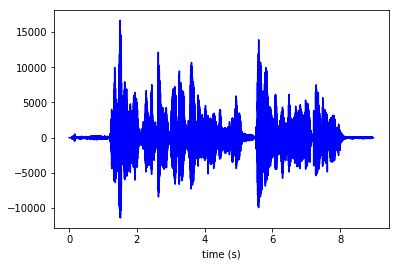

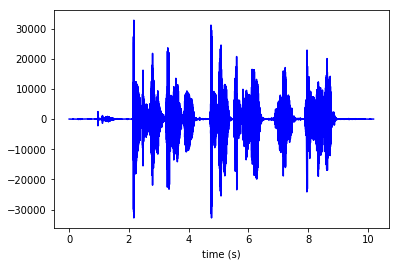

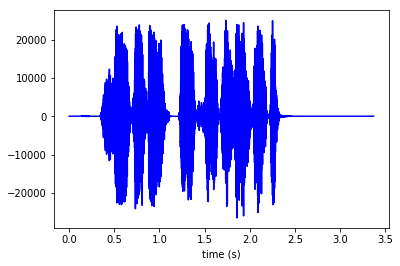

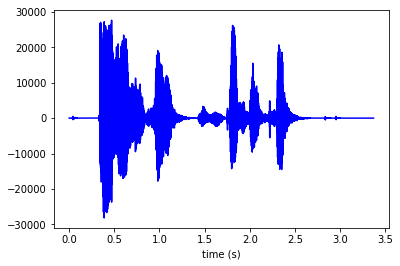

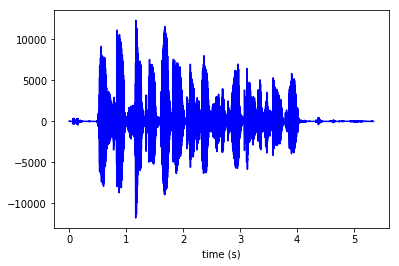

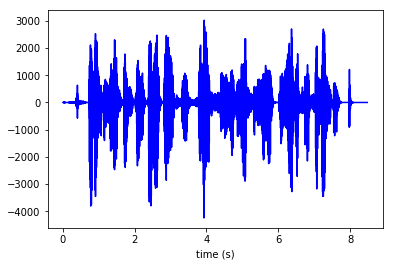

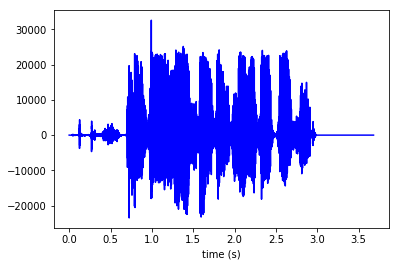

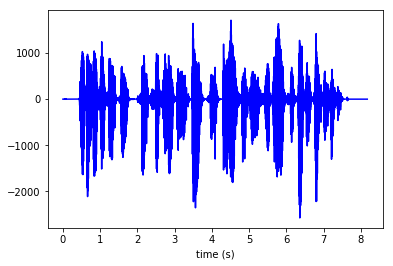

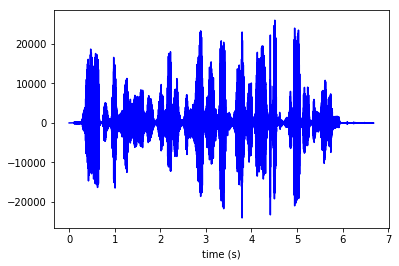

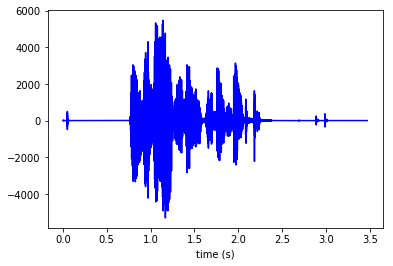

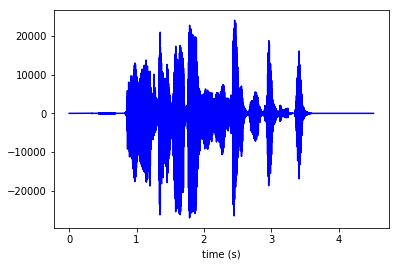

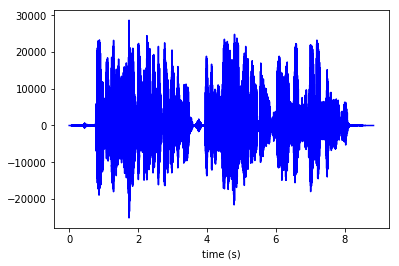

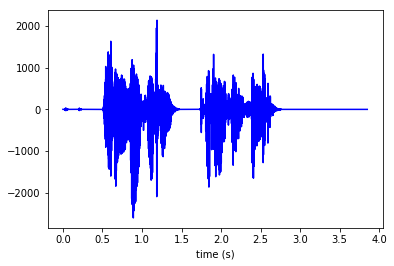

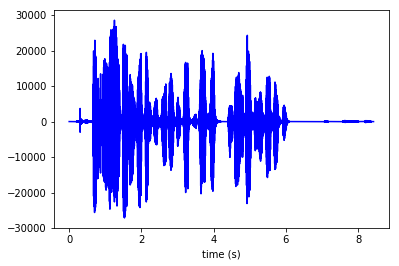

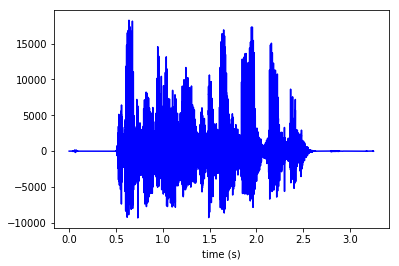

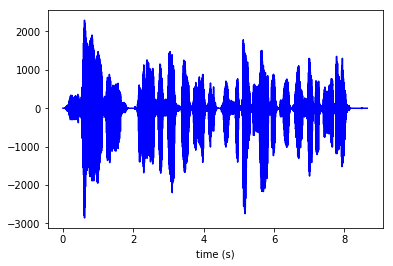

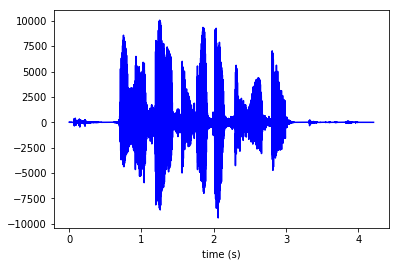

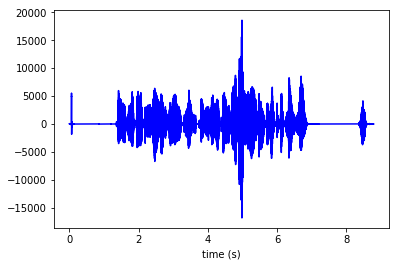

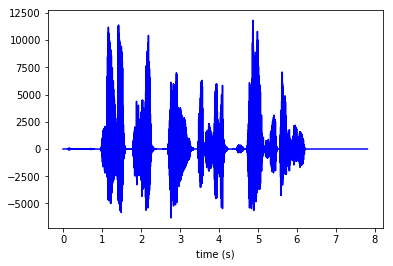

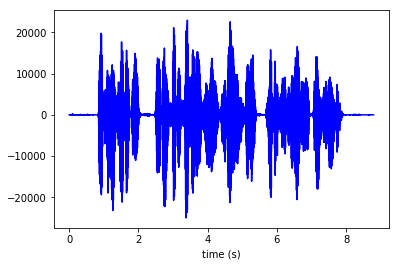

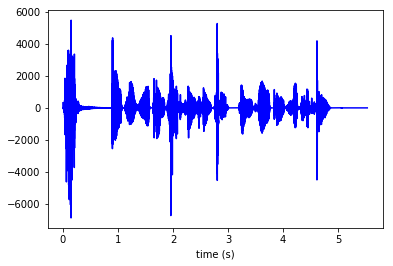

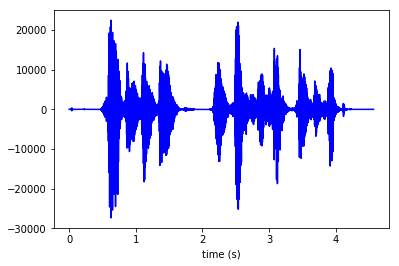

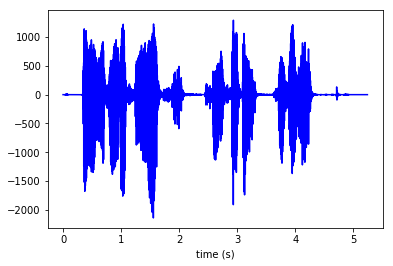

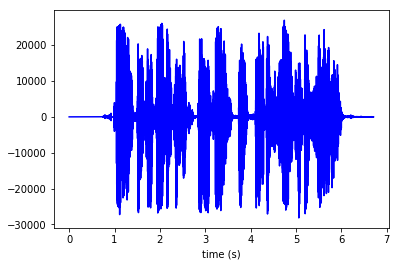

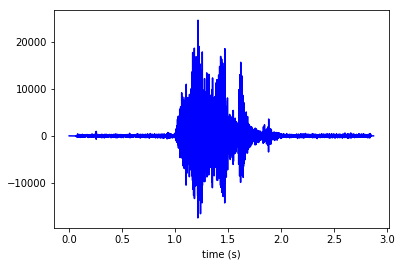

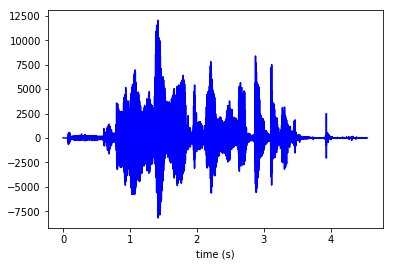

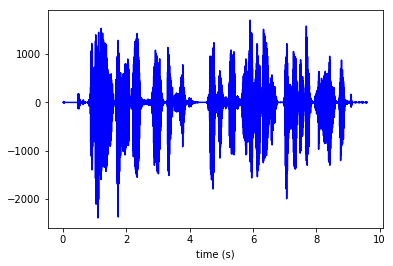

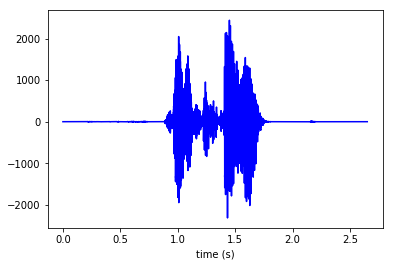

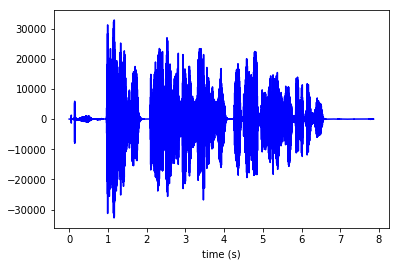

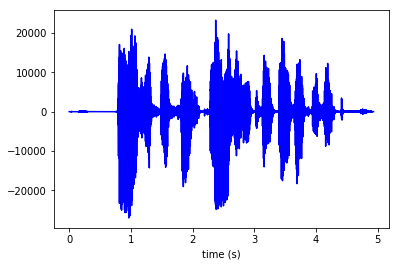

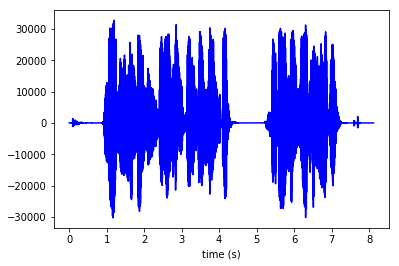

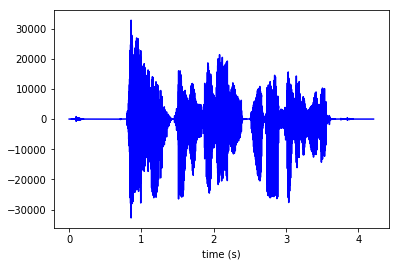

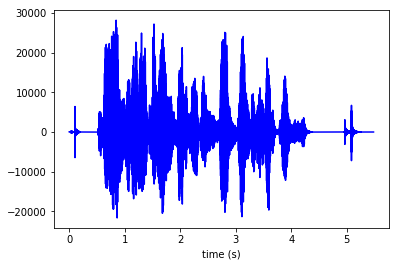

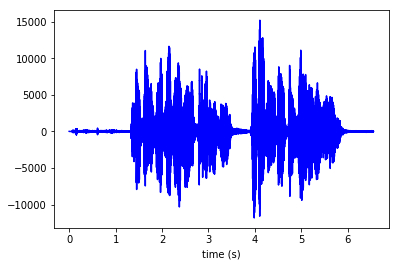

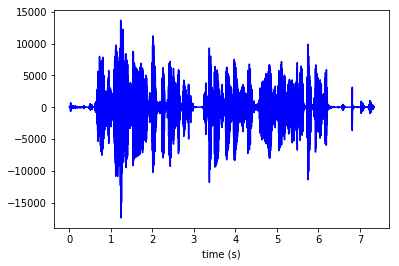

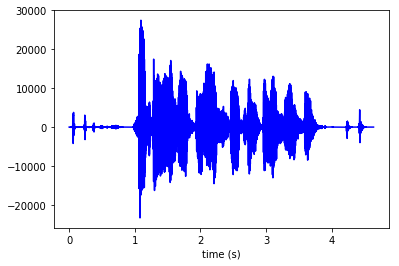

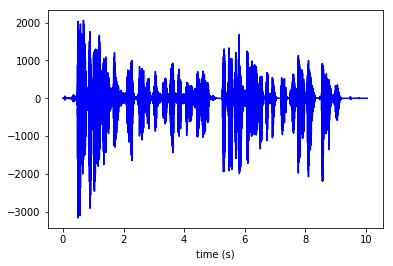

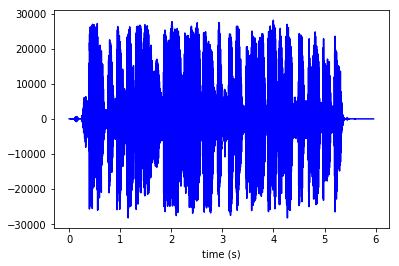

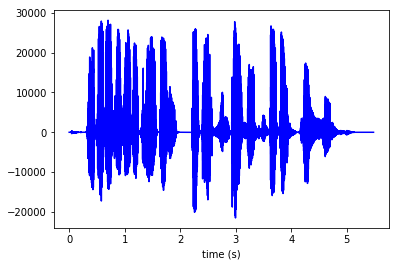

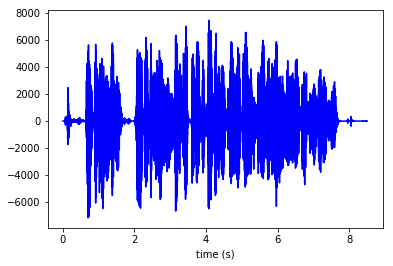

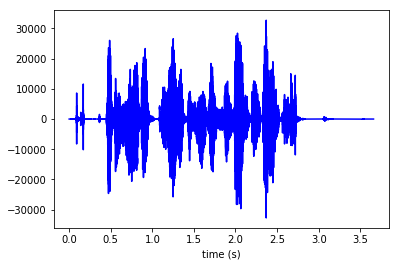

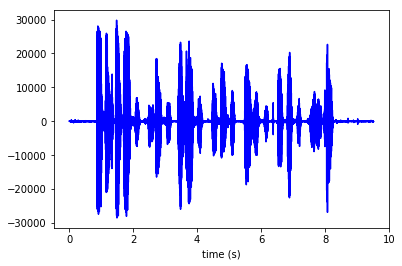

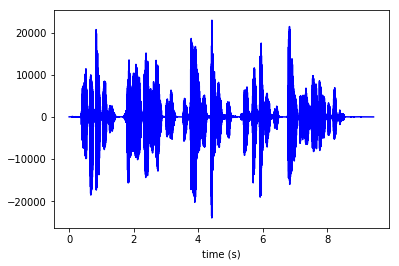

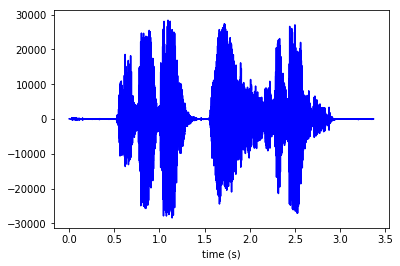

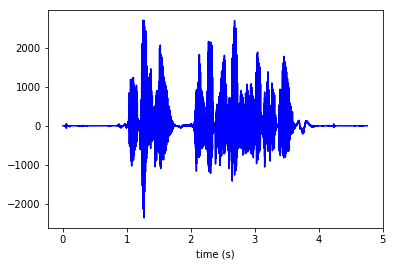

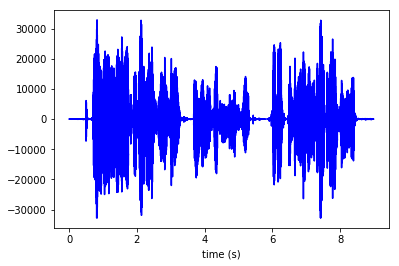

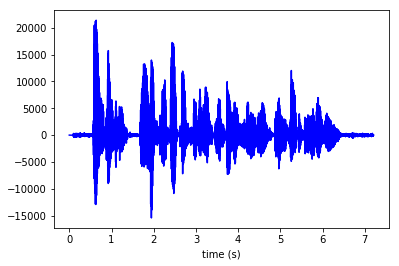

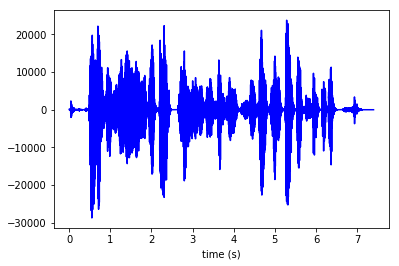

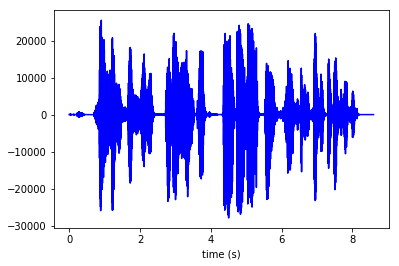

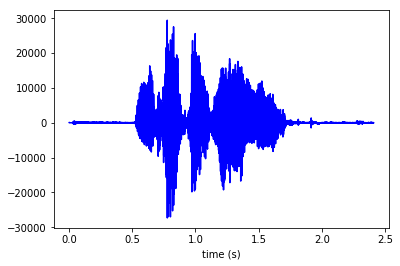

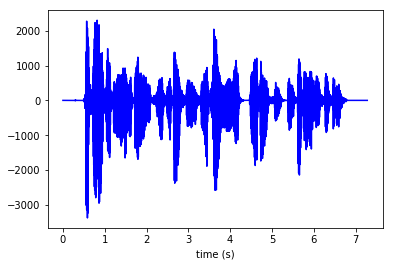

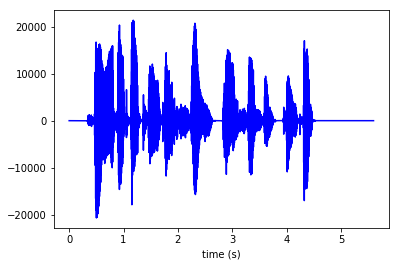

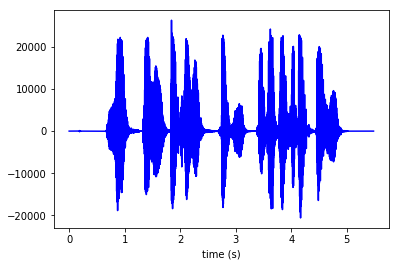

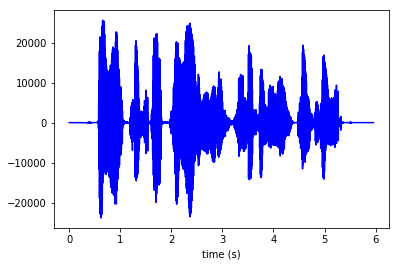

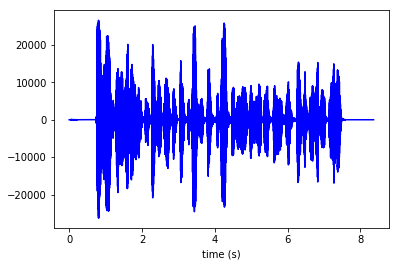

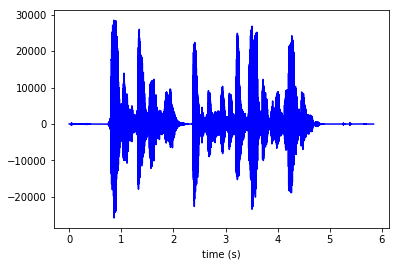

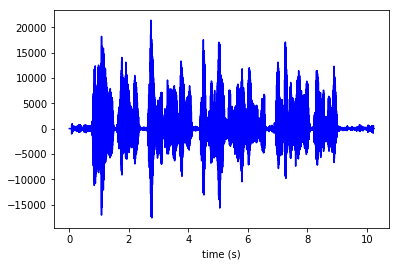

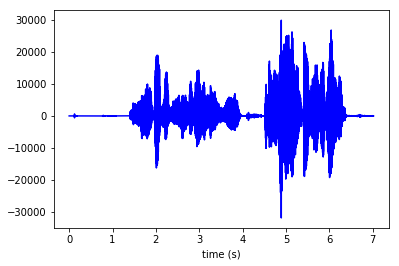

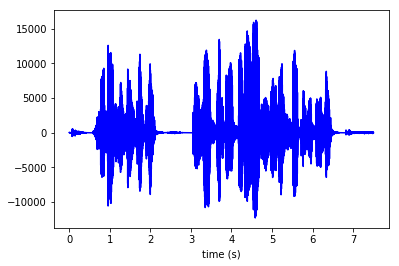

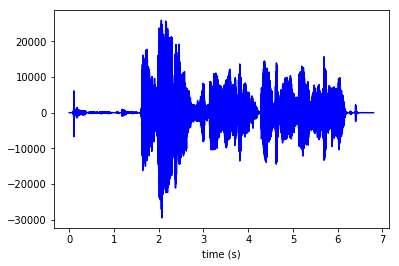

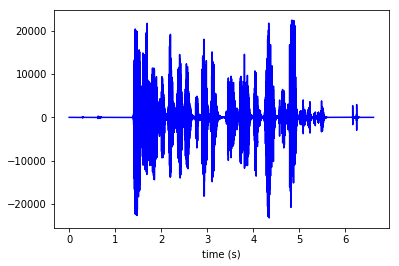

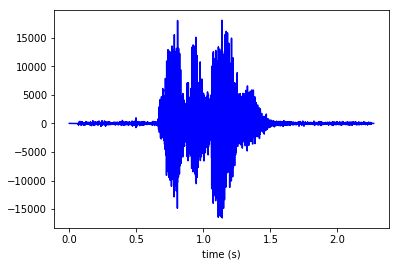

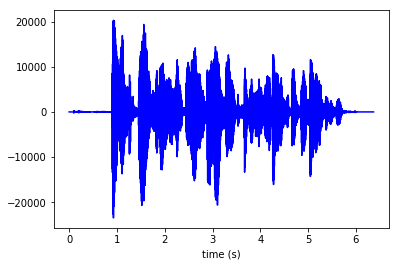

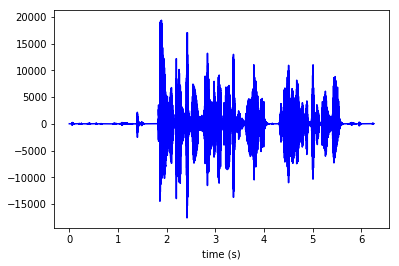

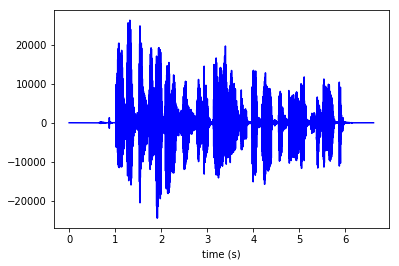

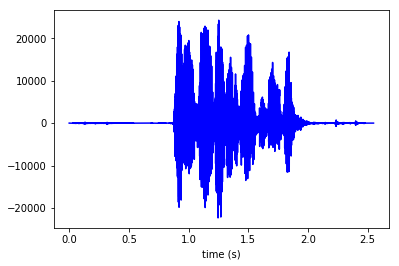

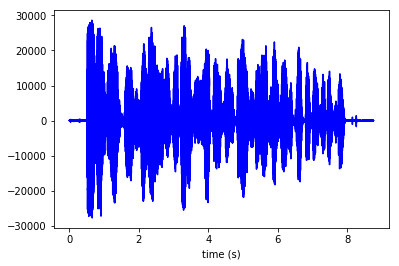

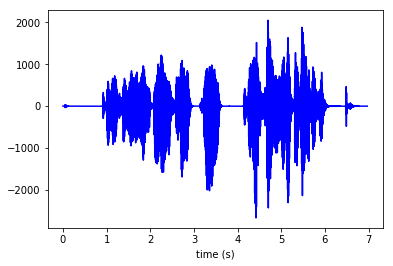

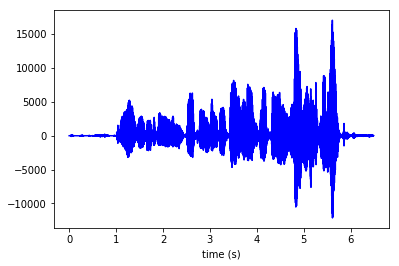

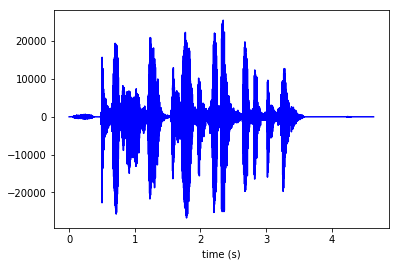

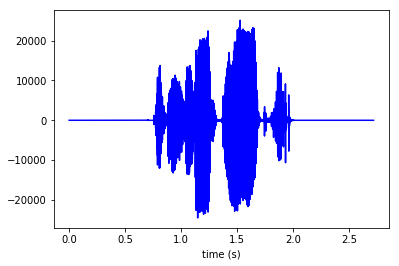

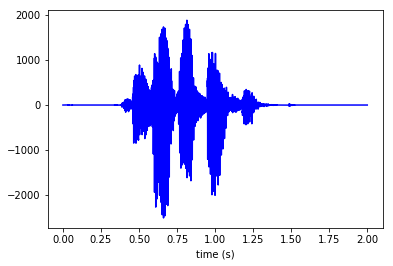

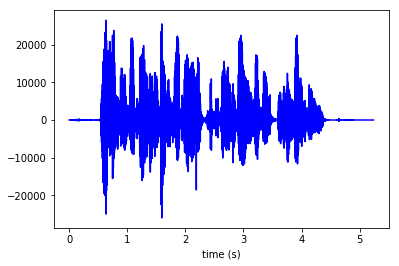

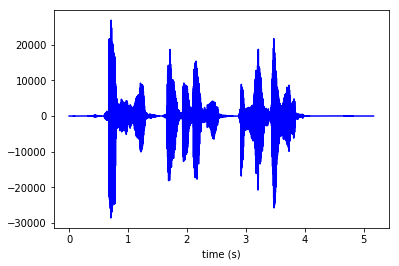

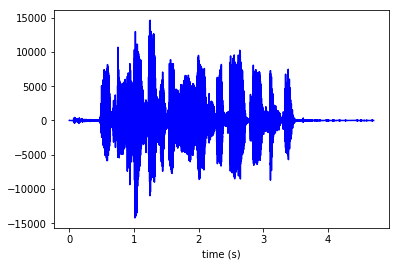

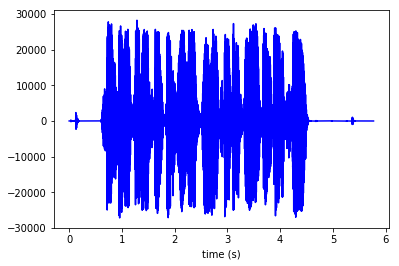

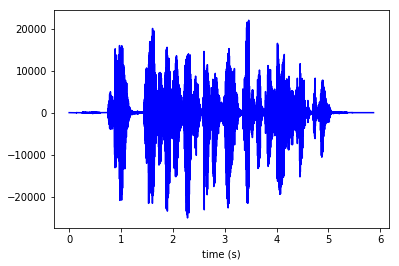

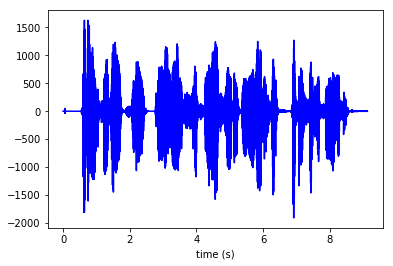

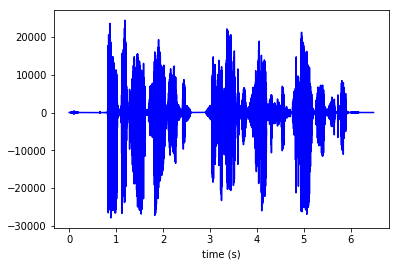

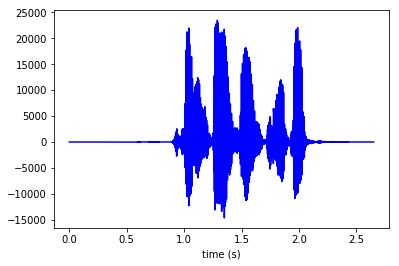

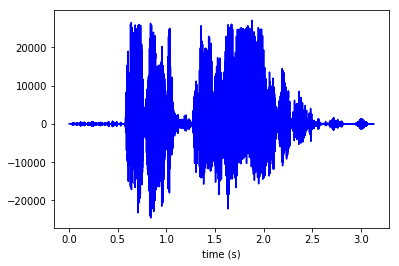

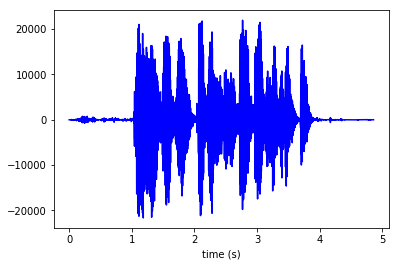

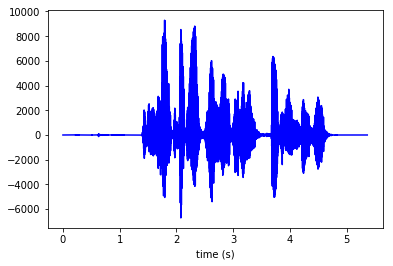

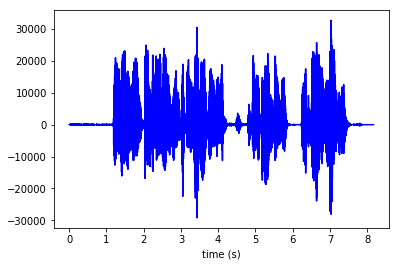

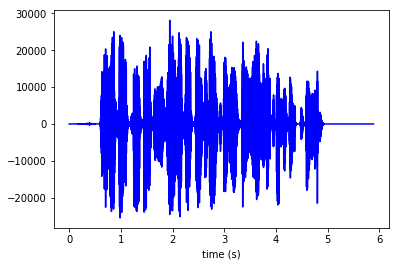

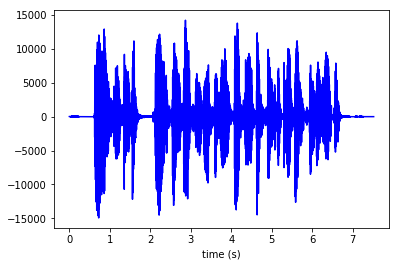

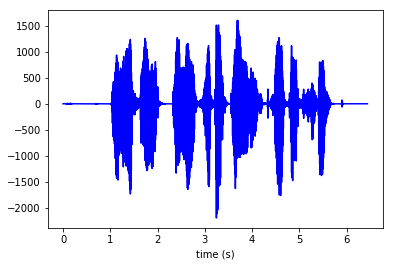

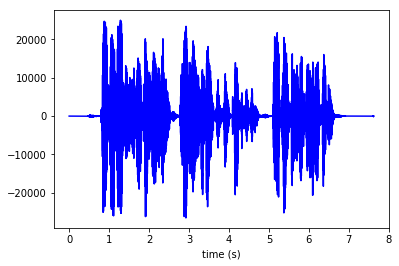

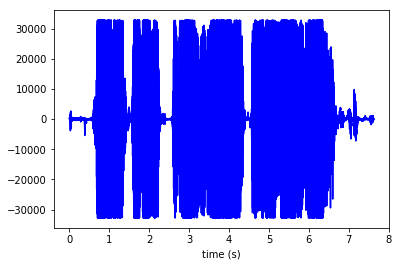

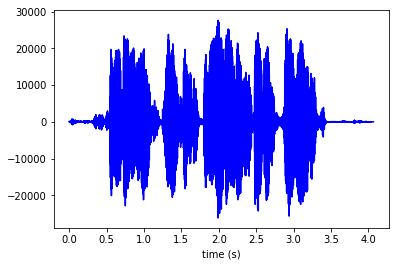

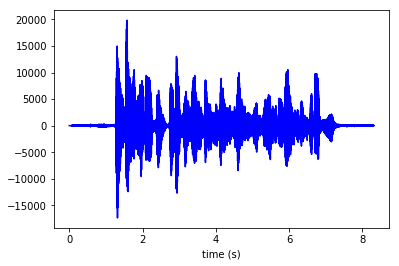

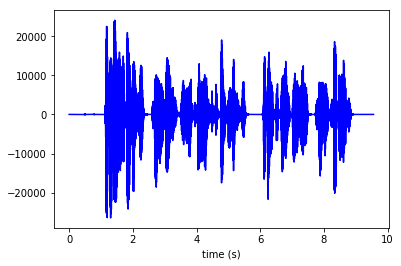

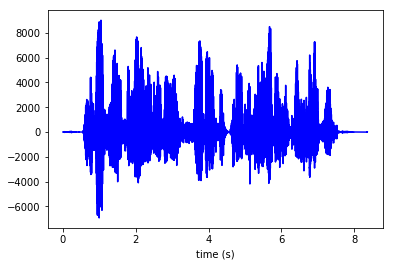

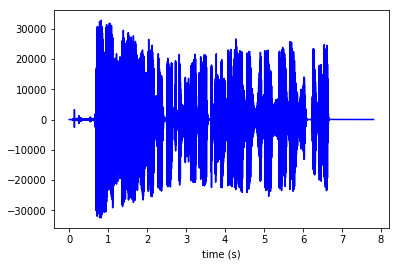

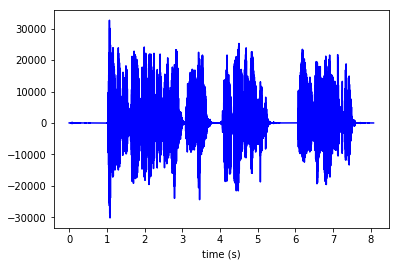

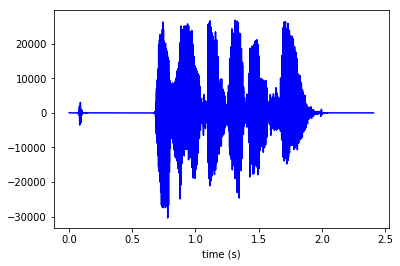

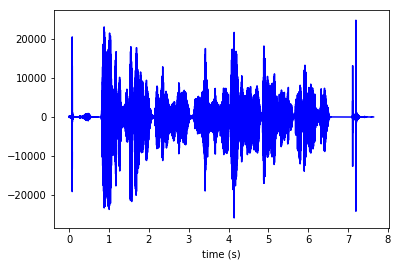

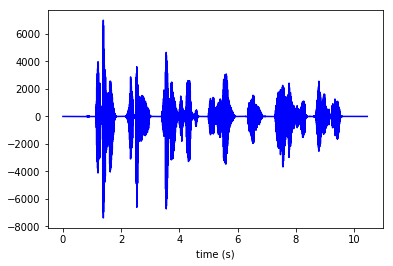

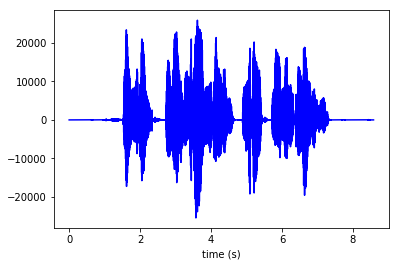

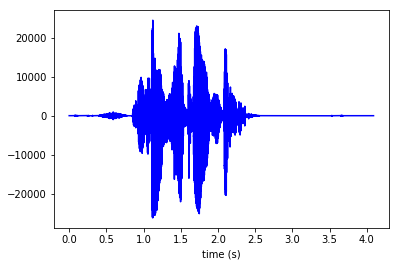

In [24]:
import os

for path in os.listdir(output_wav_dir):
    draw(file_path = os.path.join(output_wav_dir, path))  


In [27]:
import logging
import librosa

class SilenceDetector(object):
    def __init__(self, threshold=20, bits_per_sample=16):
        self.cur_SPL = 0
        self.threshold = threshold
        self.bits_per_sample = bits_per_sample
        self.normal = pow(2.0, bits_per_sample - 1)
        self.logger = logging.getLogger('balloon_thrift')

    def is_silence(self, chunk):
        self.cur_SPL = self.soundPressureLevel(chunk)
        is_sil = self.cur_SPL < self.threshold
        # print('cur spl=%f' % self.cur_SPL)
        if is_sil:
            self.logger.debug('cur spl=%f' % self.cur_SPL)
        return is_sil

    def soundPressureLevel(self, chunk):
        value = math.pow(self.localEnergy(chunk), 0.5)
        value = value / len(chunk) + 1e-12
        value = 20.0 * math.log(value, 10)
        return value

    def localEnergy(self, chunk):
        power = 0.0
        for i in range(len(chunk)):
            sample = chunk[i] * self.normal
            power += sample*sample
        return power


def silence(input_wav, output_wav):
    sil_detector = SilenceDetector(15)
    wav, sr = librosa.load(path=input_wav, sr=48000)
    new_wav = []

    for i in range(int(len(wav)/(sr*0.02))):
        start = int(i*sr*0.02)
        end = start + int(sr*0.02)
        is_silence = sil_detector.is_silence(wav[start:end])
        if not is_silence:
            new_wav.extend(wav[start:end])

    librosa.output.write_wav(output_wav, np.array(new_wav), sr)
    print(input_wav, "Finished.")

if __name__ == "__main__":
    # 示例，批处理wav文件
    for root, dirs, files in os.walk(wav_path):
        for file in files:
            input_wav = root + '/' + file
            output_wav = os.path.join(output_wav_dir, file)
            silence(input_wav, output_wav)

/home/wjunneng/Ubuntu/2019-FlyAI-Life-Scene-Chinese-Speech-Recognition/SincNet/data/input/wav/common_voice_zh-CN_18773376.wav Finished.
/home/wjunneng/Ubuntu/2019-FlyAI-Life-Scene-Chinese-Speech-Recognition/SincNet/data/input/wav/common_voice_zh-CN_18774429.wav Finished.
/home/wjunneng/Ubuntu/2019-FlyAI-Life-Scene-Chinese-Speech-Recognition/SincNet/data/input/wav/common_voice_zh-CN_18594110.wav Finished.
/home/wjunneng/Ubuntu/2019-FlyAI-Life-Scene-Chinese-Speech-Recognition/SincNet/data/input/wav/common_voice_zh-CN_18690273.wav Finished.
/home/wjunneng/Ubuntu/2019-FlyAI-Life-Scene-Chinese-Speech-Recognition/SincNet/data/input/wav/common_voice_zh-CN_18595935.wav Finished.
/home/wjunneng/Ubuntu/2019-FlyAI-Life-Scene-Chinese-Speech-Recognition/SincNet/data/input/wav/common_voice_zh-CN_18626711.wav Finished.
/home/wjunneng/Ubuntu/2019-FlyAI-Life-Scene-Chinese-Speech-Recognition/SincNet/data/input/wav/common_voice_zh-CN_18776481.wav Finished.
/home/wjunneng/Ubuntu/2019-FlyAI-Life-Scene-Chin

In [29]:
import os

for path in os.listdir(output_wav_dir):
    draw(file_path = os.path.join(output_wav_dir, path))  




Error: unknown format: 3